In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [4]:
with open('..\\data\\oscar_wind_data_U.json', 'r') as datafile:
    wind_u = json.load(datafile)[0]['data']

with open('..\\data\\oscar_wind_data_V.json', 'r') as datafile:
    wind_v = json.load(datafile)[0]['data']

with open('..\\data\\oscar_current_data_U.json', 'r') as datafile:
    current_u = json.load(datafile)[0]['data']

with open('..\\data\\oscar_current_data_V.json', 'r') as datafile:
    current_v = json.load(datafile)[0]['data']

print(wind_u[0])
print(wind_v[0])
print(current_u[0])
print(current_v[0])

-4.76
0.75
None
None


In [15]:
wind_vf = np.zeros((181, 360, 2))
current_vf = np.zeros((481, 1080, 2))
wind_mag = np.zeros((181, 360))
current_mag = np.zeros((481, 1080))

for i in range(len(current_u)):
    r = int(i / 1080)
    c = int(i % 1080)
    if (current_u[i] != None and current_v[i] != None):
        current_vf[r][c] = [current_u[i], current_v[i]]
        current_mag[r][c] = np.sqrt(pow(current_u[i], 2) + pow(current_v[i], 2))

for i in range(len(wind_u)):
    r = int(i / 360)
    c = int(i % 360)
    wind_vf[r][c] = [wind_u[i], wind_v[i]]
    wind_mag[r][c] = np.sqrt(pow(wind_u[i], 2) + pow(wind_v[i], 2))

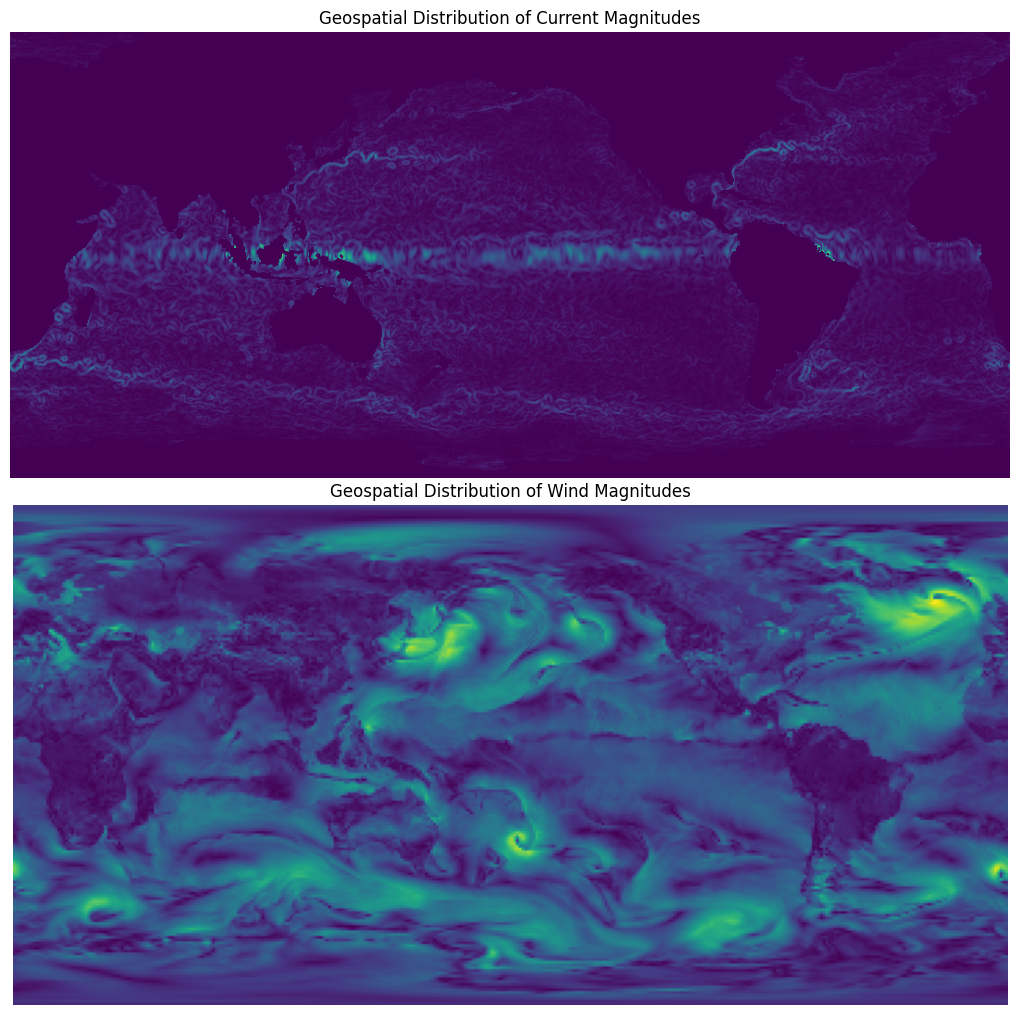

In [20]:

fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].imshow(current_mag)
ax[1].imshow(wind_mag)
ax[0].set_title('Geospatial Distribution of Current Magnitudes')
ax[1].set_title('Geospatial Distribution of Wind Magnitudes')
ax[0].axis('off')
ax[1].axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0, 0)
plt.savefig('wind_and_currents.png')

In [47]:
# latitude and longitude to r and c coordinates for current and wind

def ll_to_current_rc(lat, long):
    r = 3 * lat + 240
    if (long < 20):
        c = 3 * long + 1020
    if (long >= 20.0):
        c = 3 * long - 60
    return int(r), int(c), 480 - int(r)

def ll_to_wind_rc(lat, long):
    r = lat + 90
    if (long >= 0):
        c = long
    else:
        c = long + 360
    return int(r), int(c), 180 - int(r)